In [1]:
%matplotlib notebook

# 3) Complete spectrum analysis

In this example, we shall fit all the emission lines on the spectrum of the Green Pea galaxy GP121903 [(see Fernandez et al 2021)](https://arxiv.org/abs/2110.07741). You can download this spectrum from the [github sample data](https://github.com/Vital-Fernandez/lime/tree/master/examples/sample_data). This tutorial can also be found as a script and a notebook in the [github examples folder](https://github.com/Vital-Fernandez/lime/tree/master/examples/sample_data).

In this exercise, we are going to follow the recommended $LiMe$ workflow: Using external files with the lines
masks and fitting configuration.

Let's start by importing the script packages and defining a function to read the ISIS spectrograph *.fits* files:

In [2]:
import numpy as np
from astropy.io import fits
from IPython.display import Image, display
from pathlib import Path
import lime

In [3]:
def import_osiris_fits(file_address, ext=0):

    # Open the fits file
    with fits.open(file_address) as hdul:
        data, header = hdul[ext].data, hdul[ext].header

    # Reconstruct the wavelength array from the header data
    w_min, dw, n_pix = header['CRVAL1'],  header['CD1_1'], header['NAXIS1']
    w_max = w_min + dw * n_pix
    wavelength = np.linspace(w_min, w_max, n_pix, endpoint=False)

    return wavelength, data, header

## Scientific inputs

Now, we declare and load the scientific data:

In [4]:
# State the data files
obsFitsFile = '../sample_data/gp121903_osiris.fits'
lineBandsFile = '../sample_data/osiris_bands.txt'
cfgFile = '../sample_data/osiris.toml'

# Load spectrum
wave, flux, header = import_osiris_fits(obsFitsFile)

You can load the bands file as a [pandas dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) using the ``load_log`` function:1

In [5]:
# Load line bands
bands = lime.load_log(lineBandsFile)

This observation data and the fitting configuration on the ``cfgFile`` can be read with the ``.load_cfg`` function

In [6]:
# Load configuration
obs_cfg = lime.load_cfg(cfgFile)

# Get object redshfit and normalization flux
z_obj = obs_cfg['sample_data']['z_array'][2]
norm_flux = obs_cfg['sample_data']['norm_flux']

The ``obs_cfg`` variable is a dictionary of dictionaries, where each section and option names are keys of the parent and child dictionaries respectively:

In [7]:
import pprint
pprint.pprint(obs_cfg)

{'gp121903_line_fitting': {'Ar4_4711A_m': 'Ar4_4711A+He1_4713A',
                           'H1_3889A_m': 'H1_3889A+He1_3889A',
                           'H1_6563A_b': 'H1_6563A+N2_6584A+N2_6548A',
                           'N2_6548A_amp': {'expr': 'N2_6584A_amp/2.94'},
                           'N2_6548A_kinem': 'N2_6584A',
                           'O1_6300A_b': 'O1_6300A+S3_6312A',
                           'O2_3726A_m': 'O2_3726A+O2_3729A',
                           'O2_7319A_m': 'O2_7319A+O2_7330A',
                           'O3_5007A_b': 'O3_5007A+O3_5007A_k-1',
                           'O3_5007A_k-1_amp': {'expr': '<100.0*O3_5007A_amp',
                                                'min': 0.0},
                           'O3_5007A_k-1_sigma': {'expr': '>2.0*O3_5007A_sigma'},
                           'S2_6716A_b': 'S2_6716A+S2_6731A',
                           'S2_6731A_kinem': 'S2_6716A'},
 'sample_data': {'files_list': ['gp030321_BR.fits',
                        

## Line selection and measurement

Using these data, we can now define the ``lime.Spectrum`` object for GP121903:

<IPython.core.display.Javascript object>


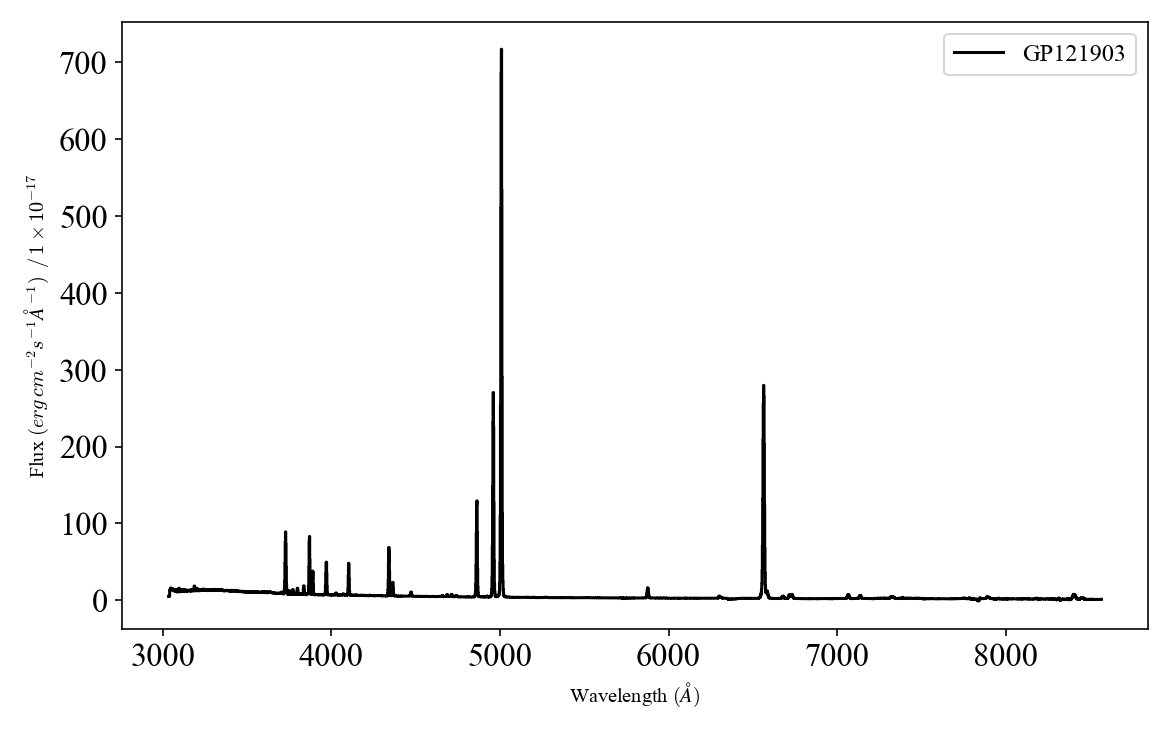

In [8]:
# Declare LiMe spectrum
gp_spec = lime.Spectrum(wave, flux, redshift=z_obj, norm_flux=norm_flux)
gp_spec.plot.spectrum(label='GP121903', rest_frame=True)

Before fitting the lines on the mask file, it is a good practice to confirm their presence of the spectrum. One way to do that is using the ``Spectrum.line_detection`` function:

In [9]:
# Find the lines
match_bands = gp_spec.line_detection(bands, cont_fit_degree=[3, 7, 7, 7], cont_int_thres=[5, 3, 2, 0.7])

This function normalizes the continuum in a loop to find the pixels above and below a certain threshold. Afterwards, the peaks or throughs found are compaired against the input line bands for a succesful line detection.

You can plot a set of bands in you spectrum with the ``line_bands`` argument in the ``.plot.spectrum`` function:

<IPython.core.display.Javascript object>


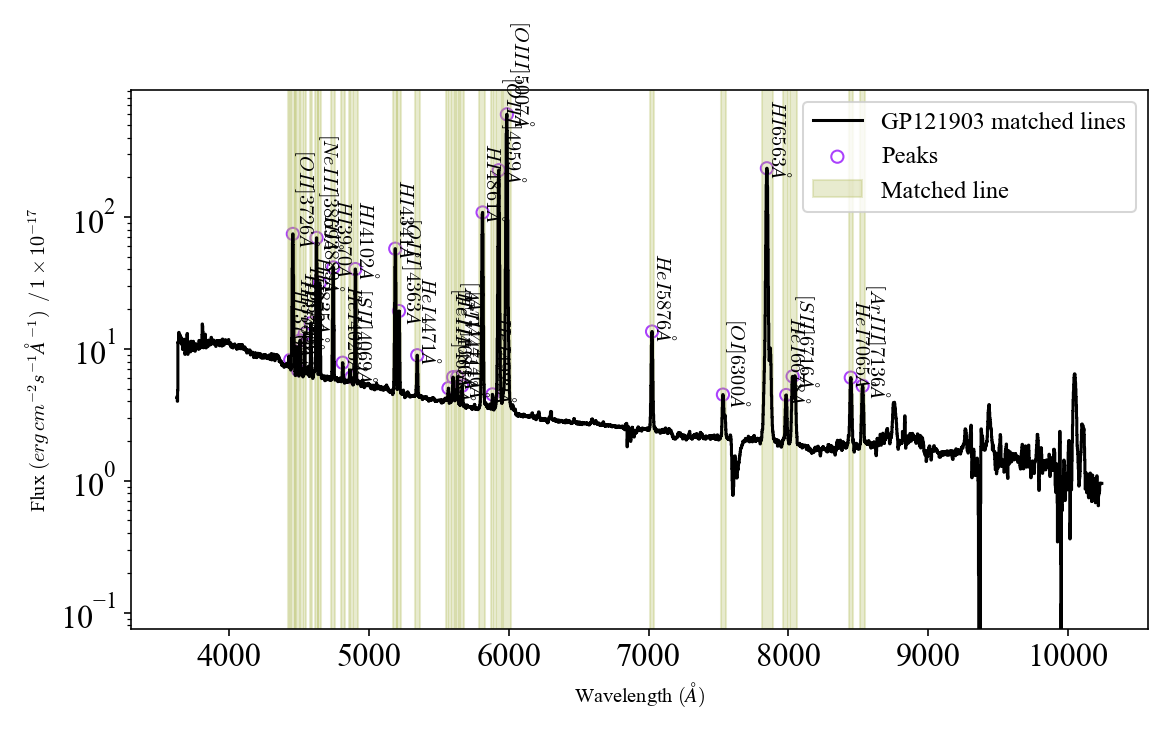

In [10]:
gp_spec.plot.spectrum(label='GP121903 matched lines', line_bands=match_bands, log_scale=True)

You can save your object bands with the ``.save_log`` function:

In [11]:
# Saving GP121903 bands
obj_bands_file = '../sample_data/gp121903_bands.txt'
lime.save_log(match_bands, obj_bands_file)

Now we are going to measure all the lines in this bands dataframe using the ``Spectrum.fit.frame`` function. This function will read the ``obj_bands_file`` and proceed to fit all the lines taking into consideration the lines fitting configuration from the ``fit_cfg`` dictionary.

In [12]:
fit_cfg = obs_cfg['gp121903_line_fitting']
gp_spec.fit.frame(obj_bands_file, fit_cfg)

[==========] 100% of 30 lines

## Plotting and saving the measurements

The fitted profiles can be over-plotted on the input spectrum setting the ``include_fits=True`` parameter on the ``Spectrum.plot.spectrum`` function

<IPython.core.display.Javascript object>


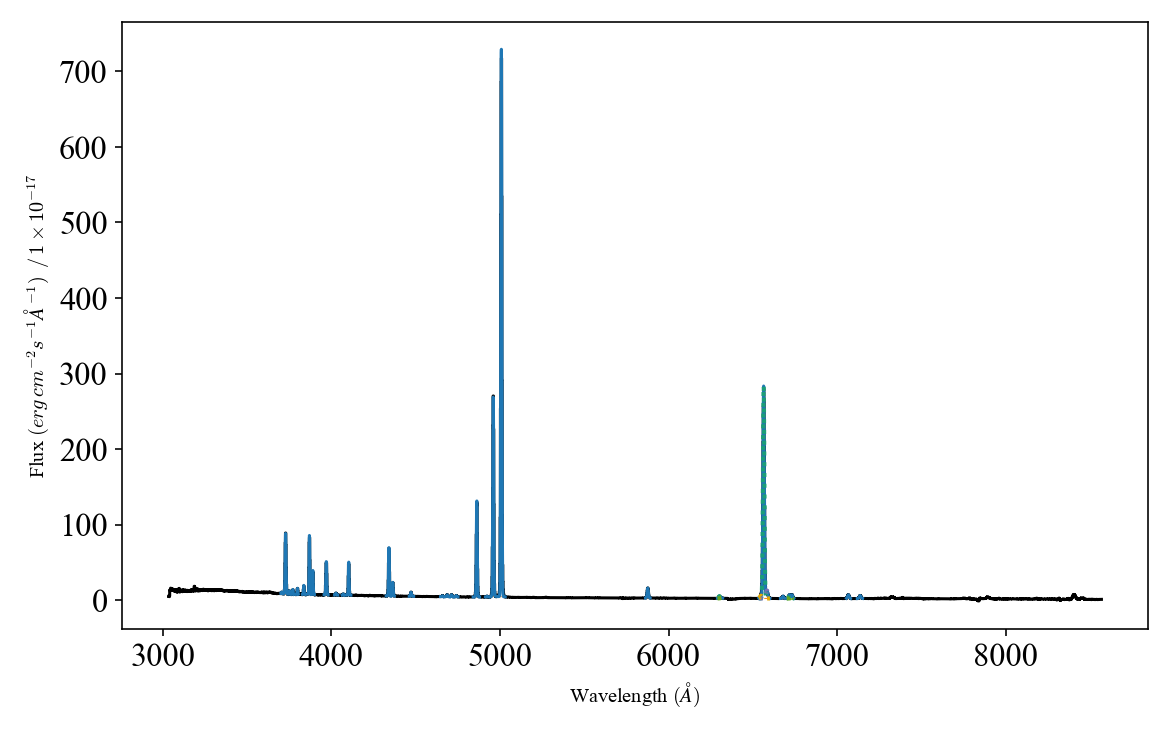

In [13]:
# Display the fits on the spectrum
gp_spec.plot.spectrum(include_fits=True, rest_frame=True)

Additionally, you can also plot the results as a grid using the ``Spectrum.plot.grid``

<IPython.core.display.Javascript object>


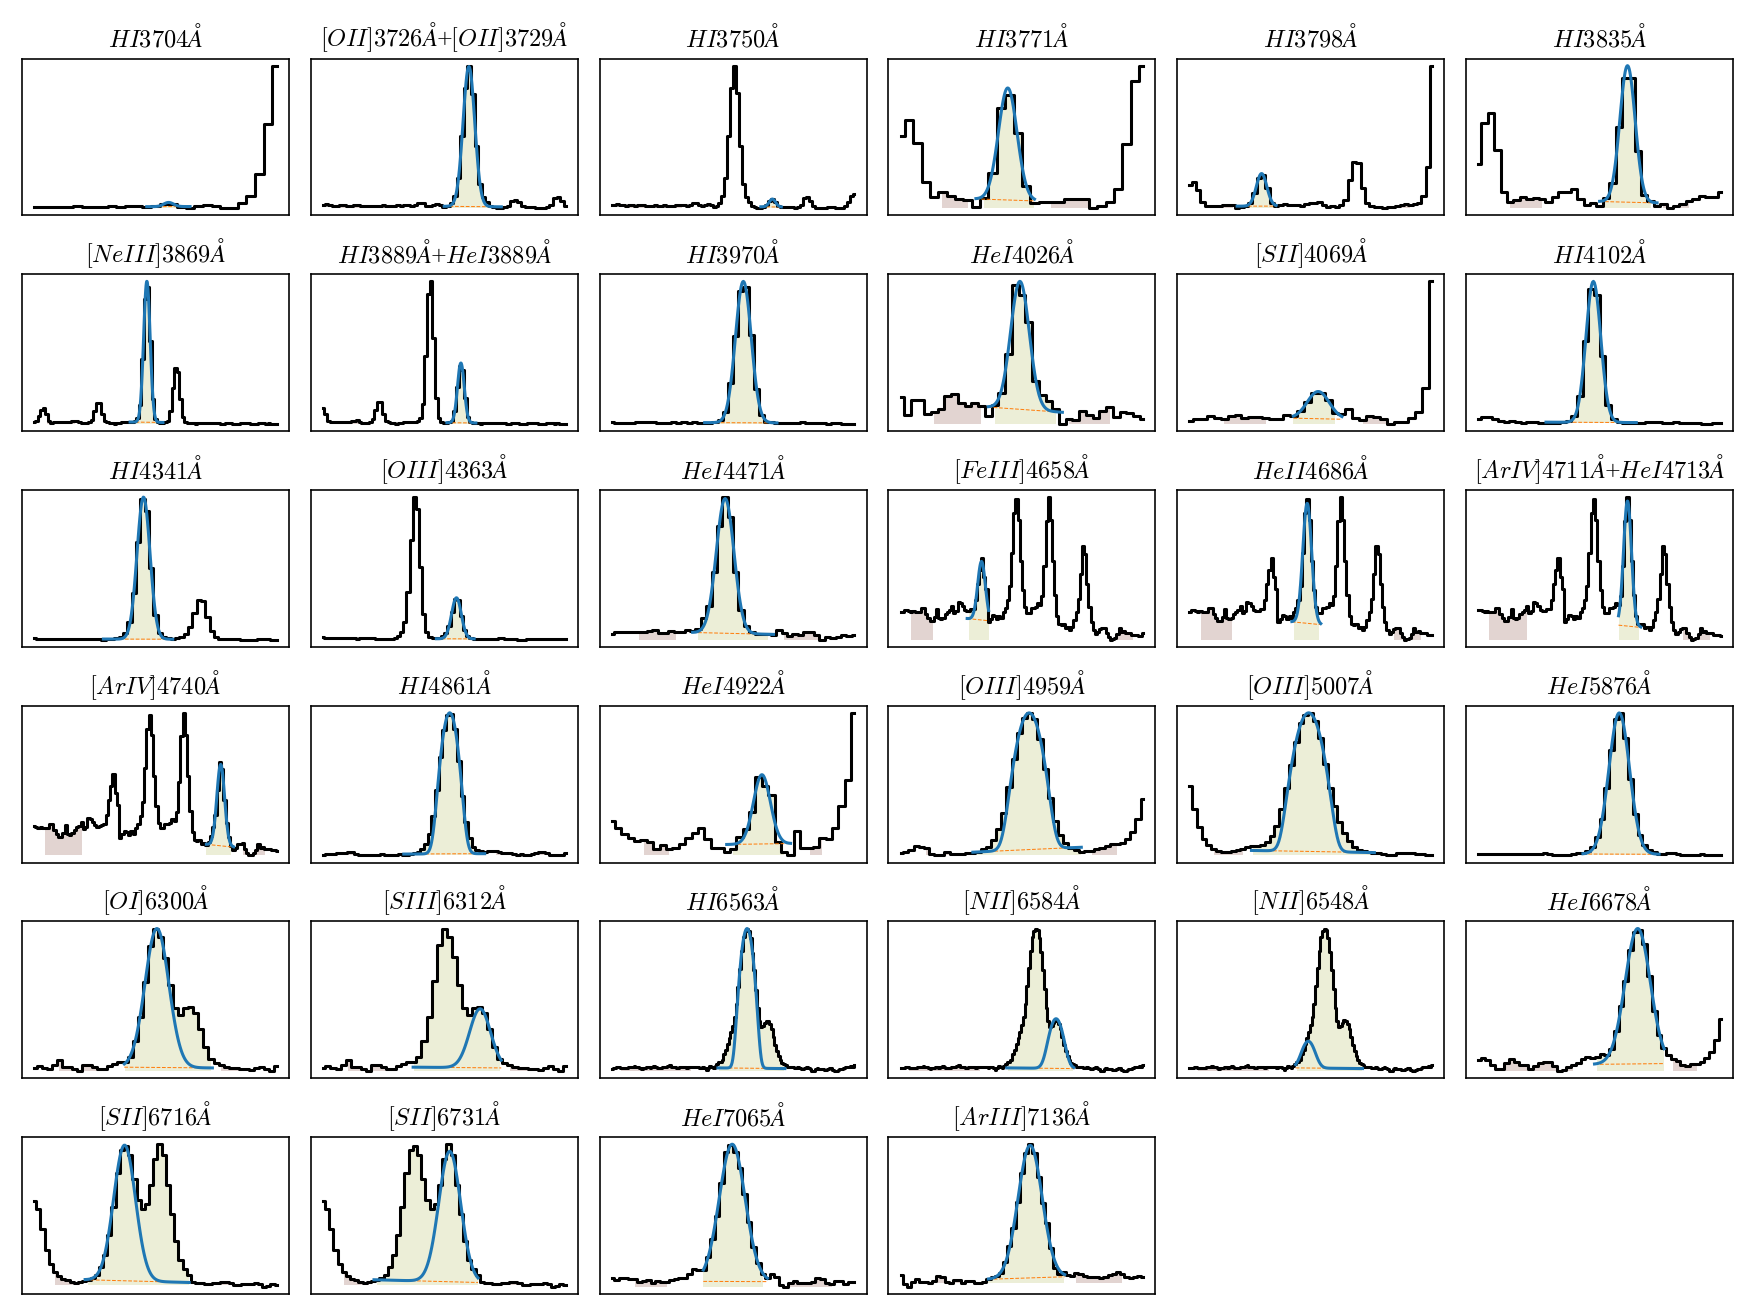

In [14]:
# Display a grid with the fits
gp_spec.plot.grid(rest_frame=True)

You can plot individual line fittings with the ``Spectrum.plot.band`` function:

<IPython.core.display.Javascript object>


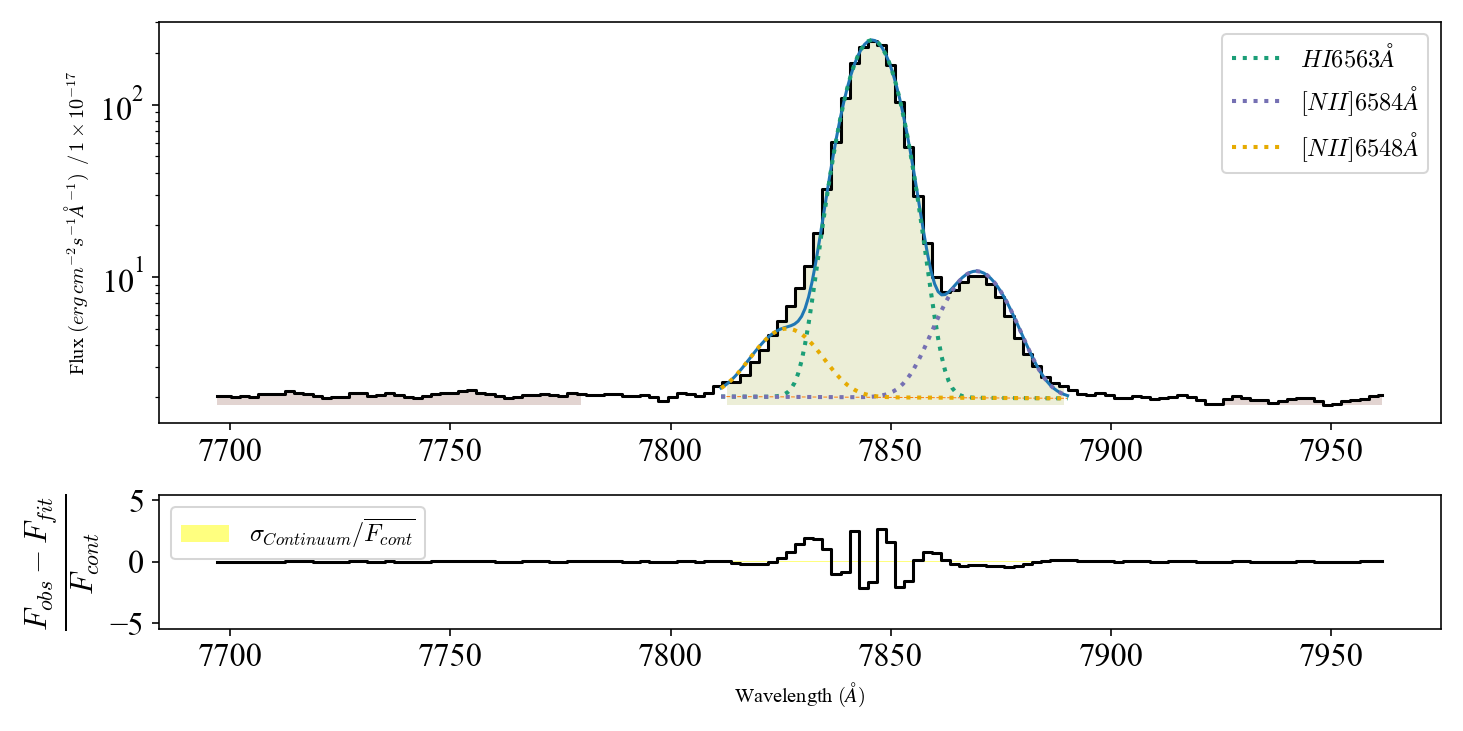

In [15]:
gp_spec.plot.bands('H1_6563A')

Finally, we save the tabulated measurements with:

In [16]:
# Save the data
gp_spec.save_log('../sample_data/example3_linelog.fits', ext='GP121903_a')

or

In [17]:
lime.save_log(gp_spec.log, '../sample_data/example3_linelog.fits', ext='GP121903b')